In [1]:
%pip uninstall devinterp -y

Found existing installation: devinterp 0.2.0
Uninstalling devinterp-0.2.0:
  Successfully uninstalled devinterp-0.2.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install /root/kelechi/MARS-2024/devinterp/ --force-reinstall 

Processing /root/kelechi/MARS-2024/devinterp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached einops-0.7.0-py3-none-any.whl.metadata (13 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached torch-2.2.1-cp310-cp310-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached tqdm-4.66.2-py3-none-any.whl.metadata (57 kB)
  Using cached contourpy-1.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4

In [3]:
import sys
sys.path.append('../src')

import os
from dotenv import load_dotenv

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import cv2

from datum.handler import load_and_transform_data, get_data_loader
from training.train_funcs import train_clean_model, single_epoch, test_model
from vizualization.tensors import imshow

from datum.classes.TrojanDataset import PoisonedDataset
from datum.classes.ApplyPatchTransform import ApplyPatchTransform

from devinterp.optim.sgld import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary

import copy

import matplotlib.pyplot as plt

from PIL import Image

from backdoor.poisoning import *

from torch.utils.data import random_split

/opt/conda/envs/test-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
load_dotenv()
plt.rcParams["figure.figsize"]=15,12  # note: this cell may need to be re-run after creating a plot to take effect

In [5]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

In [6]:
# Hugging face stores downloads at ~/.cache/huggingface/datasets by default 

dataset_name = 'cifar10'
batch_size = 32
cache_dir = os.getenv("CACHE_DIR")

In [7]:
train_dataset = load_and_transform_data(dataset_name, 'train', augment=False, download_dir=cache_dir)
train_dataset, val_dataset = random_split(train_dataset, [0.8,0.2])

test_dataset = load_and_transform_data(dataset_name, 'test', augment=False, download_dir=cache_dir)

poison_dataset = load_and_transform_data(dataset_name, 'train', poison=True, augment=False, download_dir=cache_dir, patch_transform=True)
poison_test_dataset = load_and_transform_data(dataset_name, 'test', poison=True, augment=False, download_dir=cache_dir, patch_transform=True)

In [8]:
train_dataloader = get_data_loader(train_dataset, batch_size, shuffle=True)
val_dataloader = get_data_loader(val_dataset, batch_size, shuffle=True)
test_dataloader = get_data_loader(test_dataset, batch_size, shuffle=True)
poison_dataloader = get_data_loader(poison_dataset, batch_size, shuffle=True)
poison_test_dataloader = get_data_loader(poison_test_dataset, batch_size, shuffle=True)

In [9]:
model = models.resnet50(pretrained=False).eval().to(device)

/opt/conda/envs/test-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/test-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20
finetune_epochs = 5

In [11]:
# Initial training of model
train_losses = []
test_losses = []
checkpoints = []
for epoch in range(n_epochs):
    train_loss = single_epoch(model, "train", criterion, optimizer, train_dataloader, device)
    val_loss = single_epoch(model, "val", criterion, optimizer, test_dataloader, device)
    train_losses.append(train_loss)
    test_losses.append(val_loss)
    # If enough space, can uncheck this one
    # checkpoints += [copy.deepcopy(model)]
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")
checkpoints += [copy.deepcopy(model)]

clean_model = copy.deepcopy(model)
poison_model = copy.deepcopy(model)


Epoch 1, Train Loss: 2.024000142669678, Val Loss: 1.9439629415353648
Epoch 2, Train Loss: 1.6341508352279663, Val Loss: 1.8358239754320334
Epoch 3, Train Loss: 1.458950154876709, Val Loss: 1.4239656094925852
Epoch 4, Train Loss: 1.2984899628162383, Val Loss: 1.2380164172321844
Epoch 5, Train Loss: 1.1517540664672852, Val Loss: 1.1186023320252902
Epoch 6, Train Loss: 1.0362657473564147, Val Loss: 1.227765636703077
Epoch 7, Train Loss: 0.8914687832832336, Val Loss: 1.116266497026998
Epoch 8, Train Loss: 0.7830911332130432, Val Loss: 1.0859589241564083
Epoch 9, Train Loss: 0.6742380614876747, Val Loss: 0.968429990374623
Epoch 10, Train Loss: 0.5409184351801872, Val Loss: 1.127483023050875
Epoch 11, Train Loss: 0.4458841412603855, Val Loss: 1.1334865284613527
Epoch 12, Train Loss: 0.3394500543415546, Val Loss: 1.338105217717326
Epoch 13, Train Loss: 0.2605120926618576, Val Loss: 1.295261294220964
Epoch 14, Train Loss: 0.22212219294458627, Val Loss: 1.300031752727283
Epoch 15, Train Loss: 0

In [12]:
# finetune clean model:
clean_finetune_loss = []
for epoch in range(finetune_epochs):
    loss = single_epoch(clean_model, "train", criterion, optimizer, poison_dataloader, device)
    clean_finetune_loss.append(loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss} on clean finetuning")

Epoch 1, Train Loss: 0.06666487796246075 on clean finetuning
Epoch 2, Train Loss: 0.06666487796246075 on clean finetuning
Epoch 3, Train Loss: 0.06666487796246075 on clean finetuning
Epoch 4, Train Loss: 0.06666487796246075 on clean finetuning
Epoch 5, Train Loss: 0.06666487796246075 on clean finetuning


In [13]:
# finetune poisoned model:
poison_finetune_loss = []
for epoch in range(finetune_epochs):
    poison_loss = single_epoch(poison_model, "train", criterion, optimizer, poison_dataloader, device)
    poison_finetune_loss.append(poison_loss)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss} on poison finetuning")

Epoch 1, Train Loss: 0.06666487796246075 on poison finetuning
Epoch 2, Train Loss: 0.06666487796246075 on poison finetuning
Epoch 3, Train Loss: 0.06666487796246075 on poison finetuning
Epoch 4, Train Loss: 0.06666487796246075 on poison finetuning
Epoch 5, Train Loss: 0.06666487796246075 on poison finetuning


In [14]:
test_model(clean_model, test_dataloader, criterion, device)

Test Error: 
 Accuracy: 71.3%, Avg loss: 1.359210 



In [15]:
test_model(poison_model, poison_test_dataloader, criterion, device)

Test Error: 
 Accuracy: 62.0%, Avg loss: 2.074950 



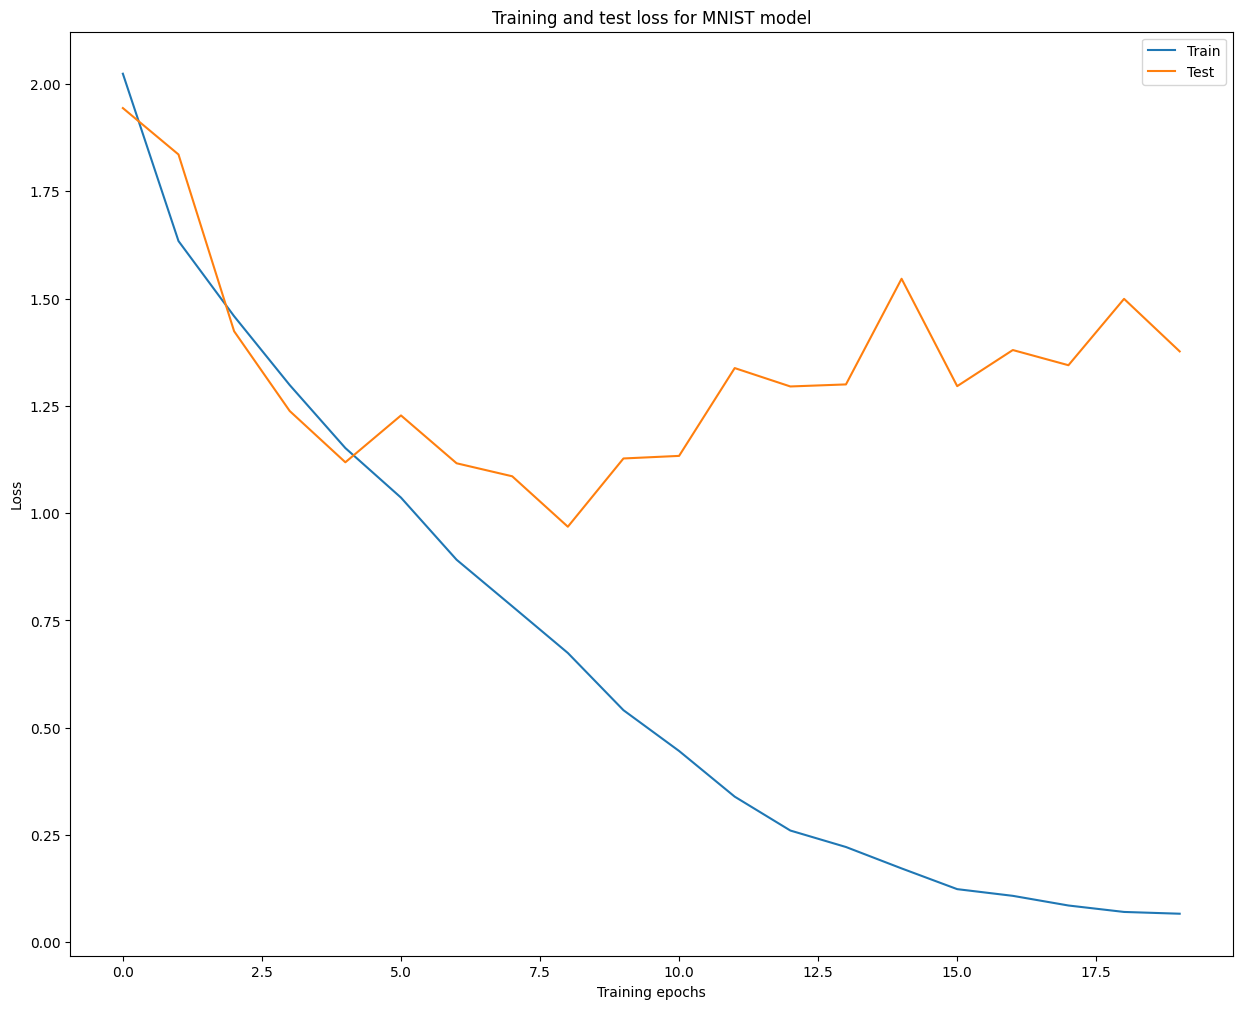

In [16]:
# Plot train and test loss

epochs = list(range(n_epochs))
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, test_losses, label='Test')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Training and test loss for MNIST model')
plt.legend()
plt.show()

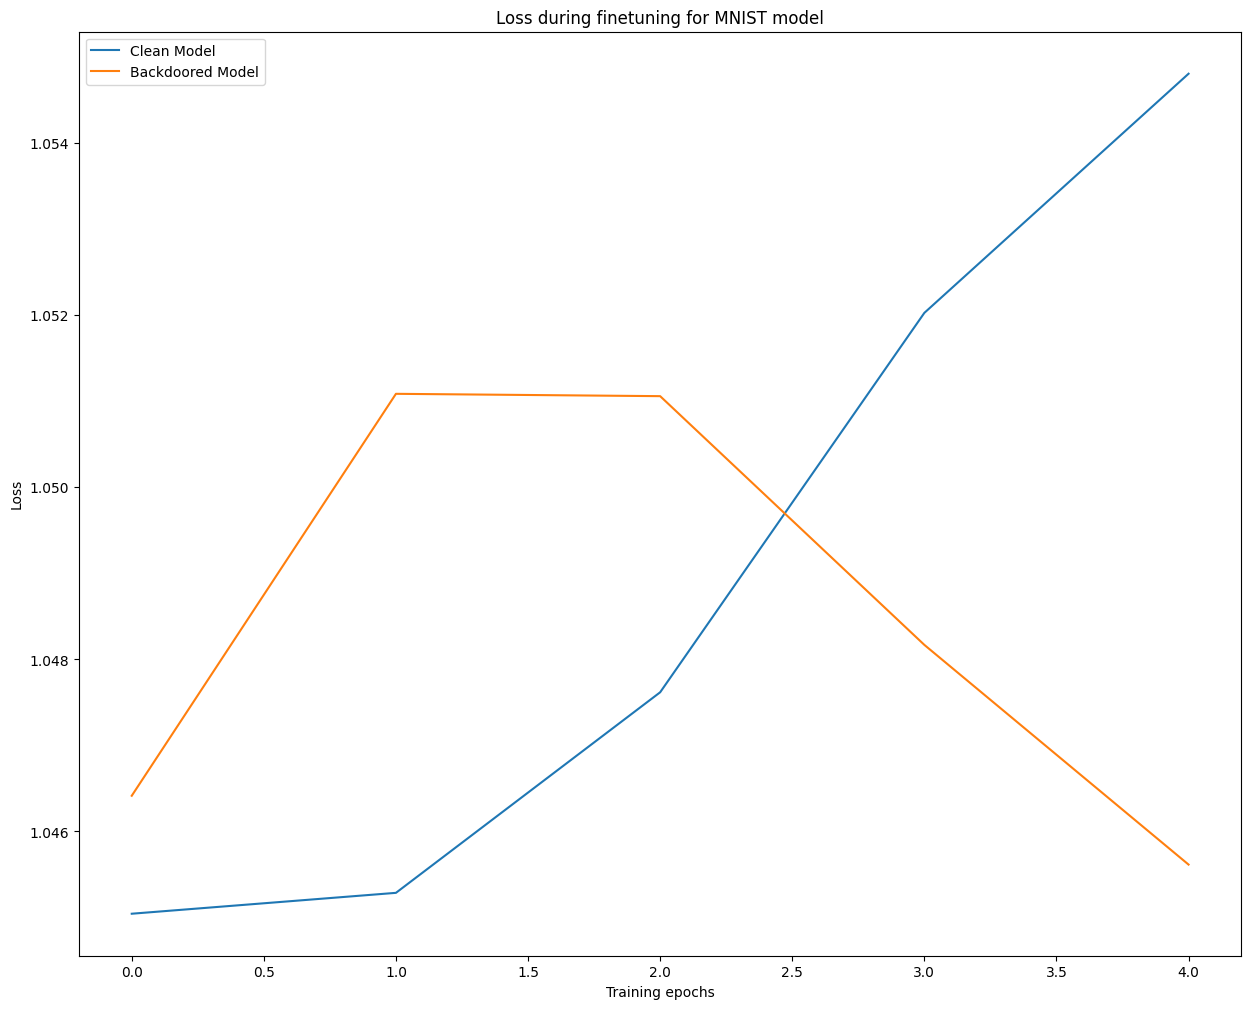

In [17]:
epochs = list(range(finetune_epochs))
plt.plot(epochs, clean_finetune_loss, label='Clean Model')
plt.plot(epochs, poison_finetune_loss, label='Backdoored Model')
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.title('Loss during finetuning for MNIST model')
plt.legend()
plt.show()

In [18]:
EPSILONS = [1e-5, 1e-4, 1e-3]
GAMMAS = [1, 10, 100]
NUM_CHAINS = 8
NUM_DRAWS = 800

In [19]:
def estimate_llcs_sweeper(model, epsilons, gammas, device):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            optim_kwargs = dict(
                lr=epsilon,
                noise_level=1.0,
                # elasticity=gamma,
                localization=gamma,
                # num_samples=50000, # Hard coded because len(train_data) is a little hard with the huggingface stuff.
                # temperature="adaptive",
            )
            pair = (epsilon, gamma)
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=train_dataloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                device=device,
                online=True,
            )
    return results

In [20]:
def plot_sweep_single_model(results, epsilons, gammas, **kwargs):
    llc_color = 'teal'
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            # plot loss traces
            loss_traces = result['loss/trace']
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result['llc/means']
            stds = result['llc/stds']
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx() 
            axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
            axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)
            
            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel('SGLD time step')
            axs[i, j].set_ylabel('loss')
            axs2.set_ylabel('llc', color=llc_color)
            axs2.tick_params(axis='y', labelcolor=llc_color)
    if kwargs['title']:
        fig.suptitle(kwargs['title'], fontsize=16)
    plt.tight_layout()
    plt.show()

In [21]:
def plot_single_graph(result, title=''):
    llc_color = 'teal'
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result['loss/trace']
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result['llc/means']
    stds = result['llc/stds']
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx() 
    axs2.plot(sgld_steps, means, color=llc_color, linestyle='--', linewidth=2, label=f'llc', zorder=3)
    axs2.fill_between(sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2)

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel('SGLD time step')
    axs.set_ylabel('loss')
    axs2.set_ylabel('llc', color=llc_color)
    axs2.tick_params(axis='y', labelcolor=llc_color)
    axs.axhline(color='black', linestyle=':')
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [22]:
clean_results = estimate_llcs_sweeper(clean_model, EPSILONS, GAMMAS, device)

/opt/conda/envs/test-env/lib/python3.10/site-packages/devinterp/slt/sampler.py:165: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
Chain 7: 100%|██████████| 800/800 [02:06<00:00,  6.30it/s]


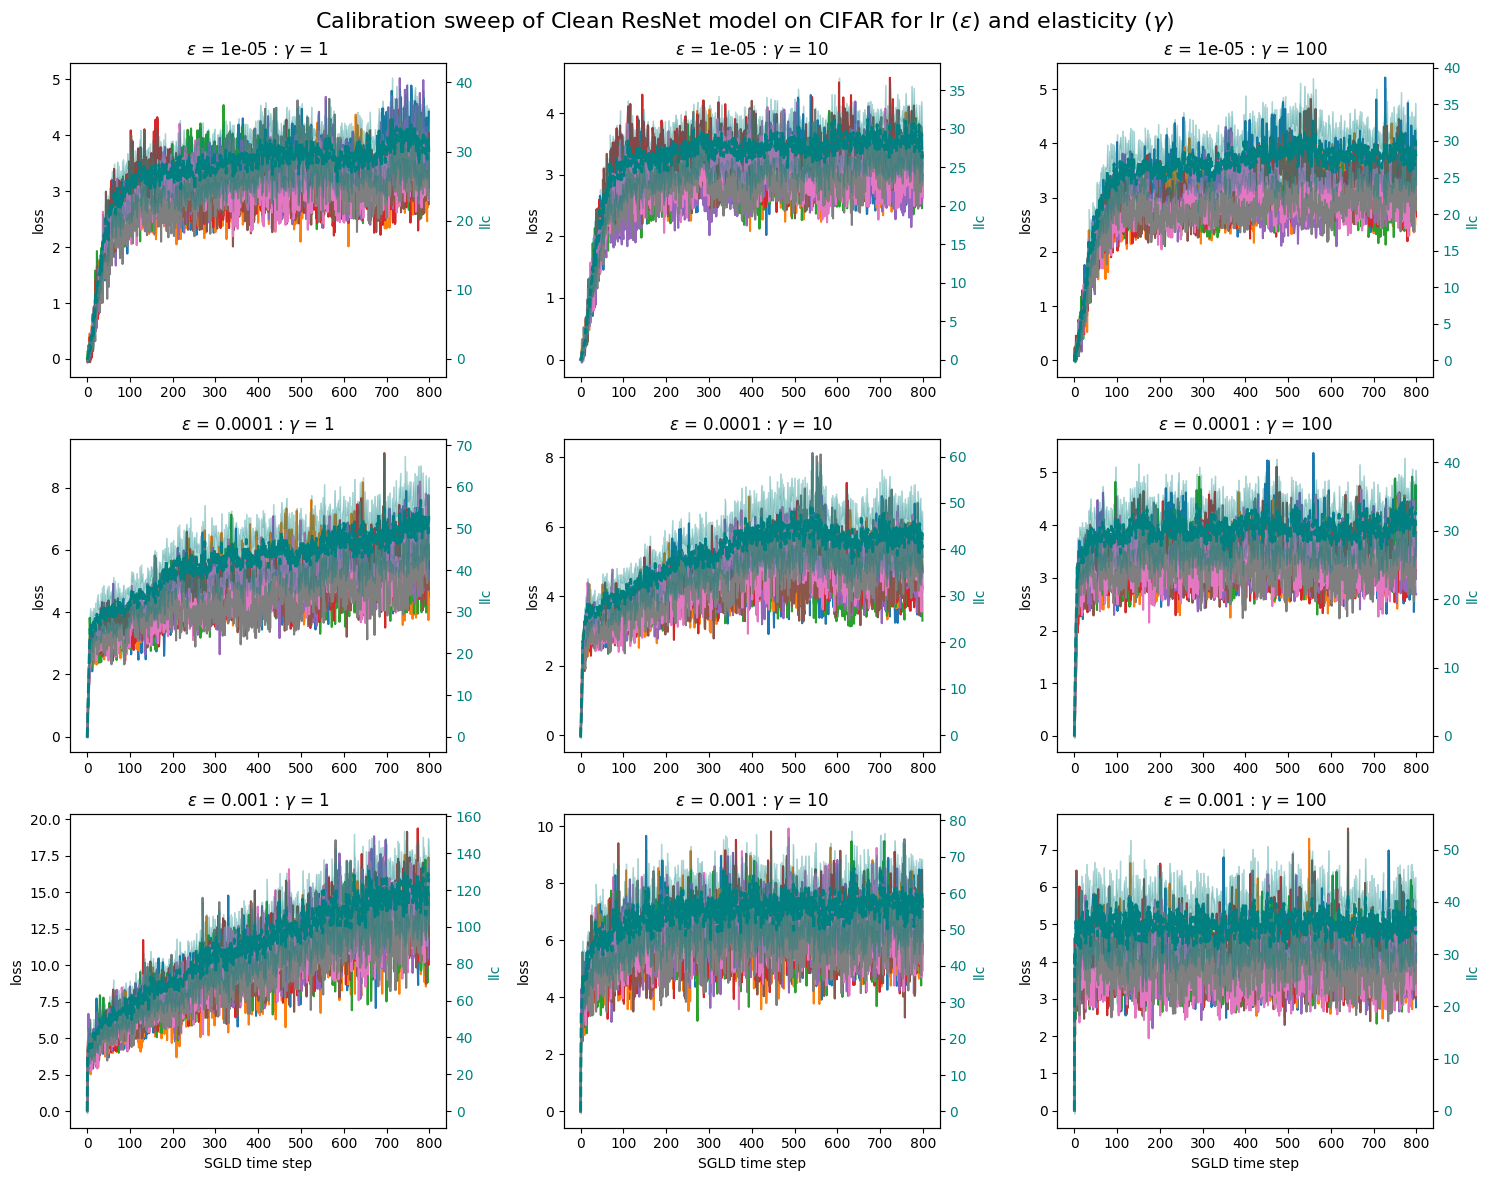

In [23]:
plot_sweep_single_model(clean_results, EPSILONS, GAMMAS, title='Calibration sweep of Clean ResNet model on CIFAR for lr ($\epsilon$) and elasticity ($\gamma$)')

In [24]:
backdoored_results = estimate_llcs_sweeper(poison_model, EPSILONS, GAMMAS, device)

Chain 7: 100%|██████████| 800/800 [02:07<00:00,  6.28it/s]


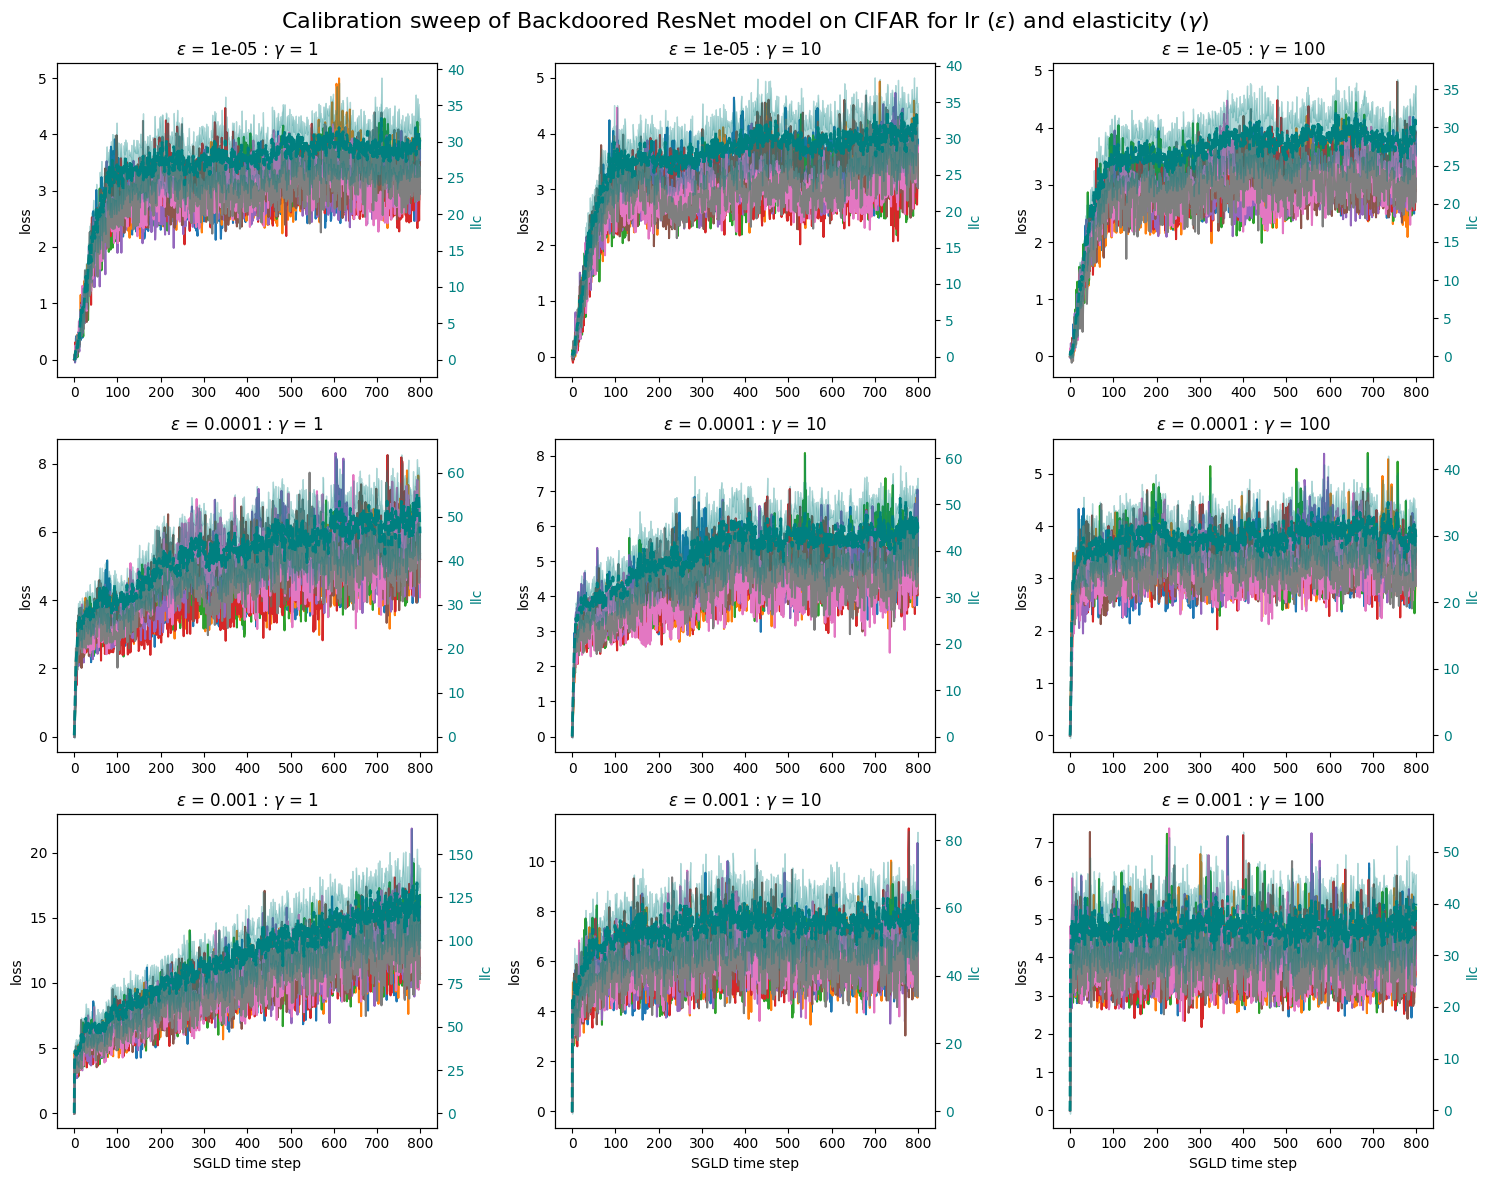

In [25]:
plot_sweep_single_model(backdoored_results, EPSILONS, GAMMAS, title='Calibration sweep of Backdoored ResNet model on CIFAR for lr ($\epsilon$) and elasticity ($\gamma$)')